# Estimer une probabilité de dépassement de seuil par les méthodes FORM-SORM - Application au cas de la poutre en flexion


## Déviation  verticale d'une poutre encastrée

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$
* $E$ : Young modulus (Pa)
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250.0, max= 260.0)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$
It is considered that failure occurs when the beam deviation is greater than 30 cm:
$$
Y \geq 30 \textrm{ (cm)}
$$
With a Monte-Carlo sample size equal to 7 120 000, we get:
$$
P(Y\geq 30) = 0.005590.
$$
The 95% confidence interval is 
$$
P([0.005536,0.005645]\ni P_f)=0.95.
$$

## References

* http://openturns.github.io/openturns/master/auto_reliability_sensitivity/reliability/plot_FORM_explained.html
* http://openturns.github.io/openturns/master/auto_reliability_sensitivity/reliability/plot_multi_form.html
* https://en.wikipedia.org/wiki/Curvature#Graph_of_a_function
* "Structural reliability", Maurice Lemaire, Wiley (2009). 
* M. Hohenbichler, S. Goldwitzer, W. Kruse and R. Rackwitz. New light on first- and second-order reliability methods. Structural Safety, 4: 267–284, 1987.
* M. Hohenbichler. Numerical Evaluation of the Error Term in Breitung’s Formula. Technical Report 69, Technical University of Munich, 1984.
* K. Breitung. Asymptotic approximations for multinormal integrals. Journal of the Engineering Mechanical Division, ASCE, 110(3): 357–366, March 1984.

# Model definition

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [4]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [5]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (cm)"])

## Utilisation de la méthode FORM

Nous créons un `ThresholdEvent` associé à l'évènement : $E = \{Y > 30\}$. La probabilité recherché est $p_f = \mathbb{P}(E)$. 

In [6]:
event = ot.ThresholdEvent(Y, ot.Greater(), 30.0)

Pour résoudre le problème d'optimisation, on utilise la méthode d'Abdo-Rackwitz, qui est spécialisée pour la méthode FORM.

In [7]:
solver = ot.AbdoRackwitz()

L'algorithme d'optimisation nécessite un point de départ dans l'espace physique. Pour cela, on utilise le centre du domaine physique c'est à dire la moyenne du vecteur aléatoire en entrée du modèle. 

In [8]:
physicalStartingPoint = X.getMean()
physicalStartingPoint

class=Point name=Unnamed dimension=4 values=[3.38065e+07,30000,255,397.5]

On peut alors utiliser la classe `FORM` et exécuter l'algorithme avec la méthode `run`. 

In [9]:
algo = ot.FORM(solver, event, physicalStartingPoint)
algo.run()
result = algo.getResult()

La méthode `getEventProbability` retourne la probabilité recherchée. 

In [10]:
pf_FORM = result.getEventProbability()
print("Probability of failure (FORM) Pf = ", pf_FORM)

Probability of failure (FORM) Pf =  0.0065821387151758235


On observe que la méthode FORM produit la solution $\hat{p}_f = 0.006582$, ce qui est relativement proche de la solution de référence: l'ordre de grandeur est correct, mais la solution n'est pas très précise. 

In [11]:
g.getEvaluationCallsNumber()

13

On observe que seulement 13 évaluations ont été nécessaires. Comparé à la méthode de Monte-Carlo, c'est une performance remarquable: lorsqu'elle fonctionne correctement, la méthode FORM est très économique. 

La méthode `getStandardSpaceDesignPoint` retourne le point de conception dans l'espace standard.

In [12]:
designPointStandardSpace = result.getStandardSpaceDesignPoint()
designPointStandardSpace

class=Point name=Standard Space Design Point dimension=4 values=[-0.604806,2.32791,0.251194,-0.54668]

On observe que la variable F (la seconde composante) possède une valeur standard $U_F$ relativement éloignée du centre du domaine, relativement aux autres.

La méthode `getIsStandardPointOriginInFailureSpace` retourne `True` si l'origine est défaillante dans l'espace standard. Ici, l'origine n'est pas défaillante dans l'espace standard. 

In [13]:
result.getIsStandardPointOriginInFailureSpace()

False

## Utilisation de la méthode SORM

Pour utiliser la méthode SORM, on utilise la classe du même nom :

In [14]:
algo = ot.SORM(solver, event, physicalStartingPoint)
algo.run()
result = algo.getResult()

In [15]:
pf_Breitung = result.getEventProbabilityBreitung()
pf_Hohenbichler = result.getEventProbabilityHohenbichler()
pf_Tvedt = result.getEventProbabilityTvedt()

print("Probability of failure (SORM Breintung) Pf = ", pf_Breitung)
print("Probability of failure (SORM Hohenbichler) Pf = ", pf_Hohenbichler)
print("Probability of failure (SORM Tvedt) Pf = ", pf_Tvedt)

Probability of failure (SORM Breintung) Pf =  0.005416445713327296
Probability of failure (SORM Hohenbichler) Pf =  0.005306863742455168
Probability of failure (SORM Tvedt) Pf =  0.005273810867877747


## Dessiner la fonction d'état limite

/home/devel/miniconda3/envs/otsupgalilee/lib/python3.9/site-packages/openturns/viewer.py:437: UserWarning: No contour levels were found within the data range.
  contourset = self._ax[0].contour(X, Y, Z, **contour_kw)


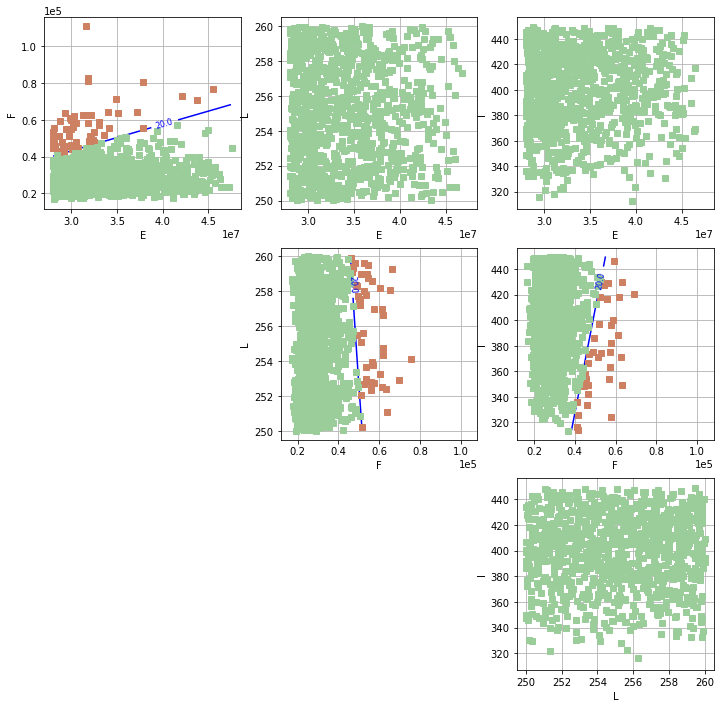

In [16]:
event = ot.ThresholdEvent(Y, ot.Greater(), 20.0)  # Lower threshold to make it fail more often.
alpha = 1.0 - 0.001
bounds, marginalProb = X.computeMinimumVolumeIntervalWithMarginalProbability(
    alpha
)
drawEvent = otb.DrawEvent(event)
_ = drawEvent.draw(bounds, nX = 100)

Plot the event in the standard space.

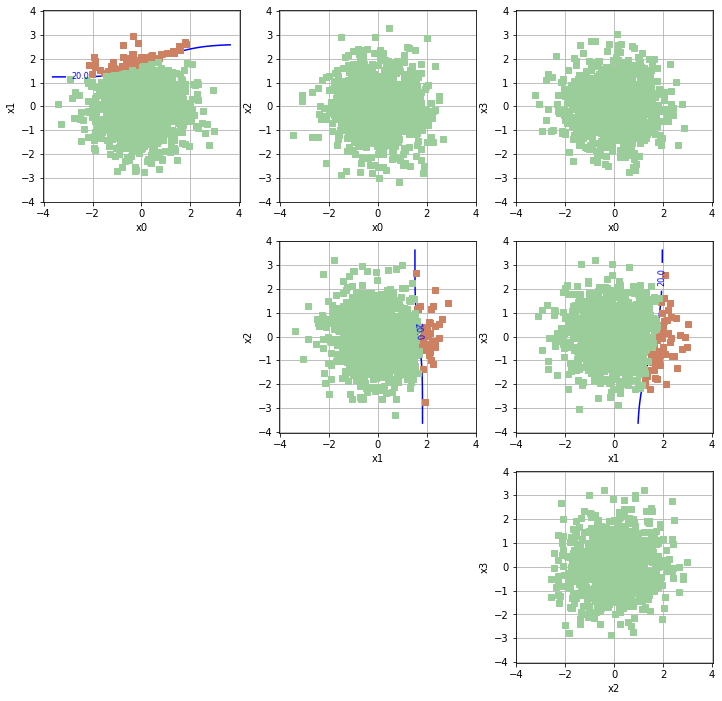

In [17]:
alpha = 1.0 - 0.001
dimension = X.getDimension()
standardDistribution = ot.Normal(dimension)
bounds, marginalProb = standardDistribution.computeMinimumVolumeIntervalWithMarginalProbability(
    alpha
)
standardEvent = ot.StandardEvent(event)
drawEvent = otb.DrawEvent(standardEvent)
_ = drawEvent.draw(bounds)

## Exercice 1 : faire varier le seuil

On souhaite observer comment la probabilité évolue lorsque le seuil change. 

*Questions*

* Changer la valeur du seuil et estimer la probabilité $p_f = \mathbb{P}(E)$ de l'évènement $E = \{Y > s\}$ pour $s=10, 15, ..., 100$ par pas de 5. 
* Pour chaque valeur du seuil, afficher la probabilité de défaillance et le nombre d'appels à la fonction $g$. Qu'observez-vous ?
* Combien d'appels au code seraient nécessaire pour estimer la probabilité $p_f$ pour le seuil $s=100$ par une méthode de Monte-Carlo simple avec un coefficient de variation égal à 0.1?
* Dessiner la probabilité estimée en fonction du seuil. Utiliser une échelle logarithmique pour l'axe des ordonnées. Quelle est l'allure générale de la courbe ?

## Solution de l'exercice 1 : faire varier le seuil

In [18]:
def calculePF(threshold):
    event = ot.ThresholdEvent(Y, ot.Greater(), threshold)
    solver = ot.AbdoRackwitz()
    algo = ot.FORM(solver, event, physicalStartingPoint)
    g.clearCache()  # otherwise, the cache saves evaluations
    evaluation_before = g.getEvaluationCallsNumber()
    algo.run()
    evaluation_after = g.getEvaluationCallsNumber()
    number_of_evaluations = evaluation_after - evaluation_before
    result = algo.getResult()
    pf_FORM = result.getEventProbability()
    print("Seuil=%.2f, Pf=%.4e, Eval.=%d" % (threshold, pf_FORM, number_of_evaluations))
    return pf_FORM, number_of_evaluations

In [19]:
threshold_array = np.arange(10.0, 100.0, 5)
nb_experiments = len(threshold_array)
pf_array = ot.Sample(nb_experiments, 2)
for i in range(nb_experiments):
    threshold = threshold_array[i]
    pf_FORM, number_of_evaluations = calculePF(threshold)
    pf_array[i, 0] = threshold
    pf_array[i, 1] = pf_FORM

Seuil=10.00, Pf=6.9555e-01, Eval.=5
Seuil=15.00, Pf=2.2813e-01, Eval.=6
Seuil=20.00, Pf=6.4590e-02, Eval.=9
Seuil=25.00, Pf=1.9628e-02, Eval.=7
Seuil=30.00, Pf=6.5821e-03, Eval.=13
Seuil=35.00, Pf=2.4177e-03, Eval.=15
Seuil=40.00, Pf=9.6076e-04, Eval.=17
Seuil=45.00, Pf=4.0832e-04, Eval.=19
Seuil=50.00, Pf=1.8383e-04, Eval.=20
Seuil=55.00, Pf=8.6984e-05, Eval.=20
Seuil=60.00, Pf=4.2984e-05, Eval.=23
Seuil=65.00, Pf=2.2067e-05, Eval.=26
Seuil=70.00, Pf=1.1718e-05, Eval.=28
Seuil=75.00, Pf=6.4130e-06, Eval.=154
Seuil=80.00, Pf=3.6062e-06, Eval.=29
Seuil=85.00, Pf=2.0781e-06, Eval.=36
Seuil=90.00, Pf=1.2245e-06, Eval.=39
Seuil=95.00, Pf=7.3631e-07, Eval.=41


On observe que le nombre d'appel évolue un peu lorsque le seuil augmente. Toutefois, il reste toujours inférieur à 200. 

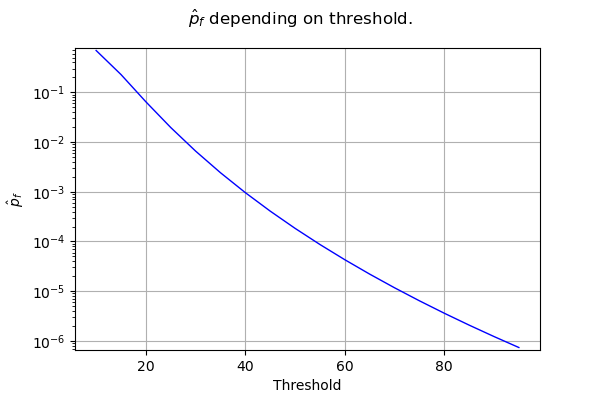

In [20]:
graph = ot.Graph(r"$\hat{p}_f$ depending on threshold.", "Threshold", r"$\hat{p}_f$", True)
curve = ot.Curve(pf_array)
graph.add(curve)
graph.setLogScale(ot.GraphImplementation.LOGY)
graph

On observe que la courve est approximativement linéaire en échelle logarithmique. 

On a déjà démontré que le nombre d'appels à la fonction $g$ pour obtenir un coefficient de variation CV est égal à  :

$$
n \approx \frac{1}{p_f CV^2},
$$

si $p_f \approx 0$. 

On calcule pf pour s=100 :

In [21]:
pf_FORM, number_of_evaluations = calculePF(100.0)
pf_FORM, number_of_evaluations

Seuil=100.00, Pf=4.5110e-07, Eval.=34


(4.5109505392032074e-07, 34)

In [22]:
CV = 0.1
n_MonteCarlo = 1.0 / (pf_FORM * CV ** 2)
n_MonteCarlo

221682767.59173578

Il faut plus de $2 \times 10^8$ appels au code pour estimer cette probabilité par la méthode de Monte-Carlo simple.

## Exercice 2 : vérifier le calcul FORM

$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

Soit $g_s$ la fonction d'état limite :

$$
g_s(\vect{x}) = s - g(\vect{x})
$$

pour tout $\vect{x}\in\mathbb{R}^p$. 

Soit $h$ la fonction issue de la composition de la transformation isoprobabiliste $T$ et de la fonction $g_s$ :

$$
h(\vect{u}) = g_s\left[T^{-1}(\vect{u})\right]
$$

pour tout $\vect{u}\in\mathbb{R}^p$. 

On a vu en cours que, si la fonction $h$ est linéaire dans l'espace standard, alors :

$$
p_f = 
\begin{cases}
\Phi(-\beta) & \textrm{ si l'origine de l'espace standard est fiable}, \\
\Phi(\beta) & \textrm{sinon.}
\end{cases}
$$

où $\Phi$ est la fonction de répartition de la loi Gaussienne standard. 

Voir également sur ce sujet (Lemaire, 2009), p.170, Proposition 1.

*Questions*

* Utiliser le seuil $s=30$ et la méthode FORM pour obtenir le résultat. 
* Utiliser la méthode `getIsStandardPointOriginInFailureSpace` pour déterminer si l'origine de l'espace standard est défaillante ou non. 
* Calculer l'estimation FORM de la probabilité.

## Solution de l'exercice 2 : vérifier le calcul FORM

In [23]:
event = ot.ThresholdEvent(Y, ot.Greater(), 30.0)
solver = ot.AbdoRackwitz()
algo = ot.FORM(solver, event, physicalStartingPoint)
algo.run()
result = algo.getResult()
beta = result.getHasoferReliabilityIndex()
beta

2.4792939279338984

On trouve que l'indice de fiabilité $\beta=2.479$. 

In [24]:
isOriginFail = result.getIsStandardPointOriginInFailureSpace()
isOriginFail

False

L'origine de l'espace standard est fiable. C'est donc la seconde branche du `if` suivant qui est utilisée.

In [25]:
normal = ot.Normal()
if isOriginFail:
    my_pf_FORM = normal.computeCDF(beta)
else:
    my_pf_FORM = normal.computeCDF(-beta)
    # or : my_pf_FORM = normal.computeComplementaryCDF(beta)
    
print("Check pf FORM=", my_pf_FORM)

Check pf FORM= 0.0065821387151758235


On peut vérifier que c'est le même résultat que la méthode `getEventProbability`.

In [26]:
result.getEventProbability()

0.0065821387151758235

## Exercice 3 : vérifier l'équation SORM

L'approximation asymptotique de Breitung (voir (Breitung, 1984) et (Lemaire, 2009), p.190, eq.7.20) est :

$$
\hat{p}_f = \frac{\Phi(-\beta)}{\prod_{i=1}^p \sqrt{1 + \beta \kappa_i}}
$$

où $\kappa_i$ est la ième courbure.

L'approximation précédente ne peut être appliquée que si $1 + \beta \kappa_i > 0$ pour $i=1,\ldots, p$. Elle n'est valide que pour des valeurs de $\beta$ grandes c'est à dire si $\beta\rightarrow +\infty$.

Une amélioration de l'approximation de Breitung est celle de Hohenbichler (voir (Hohenbichler, 1984) et (Lemaire, 2009), p.194):

$$
\hat{p}_f = \frac{\Phi(-\beta)}{\prod_{i=1}^p \sqrt{1 + \frac{\phi(\beta)}{\Phi(-\beta)} \kappa_i}}.
$$


L'objectif de cet exercice est d'utiliser les approximations SORM de Breitung et Hohenbichler pour vérifier le calcul OpenTURNS. 

*Questions*

* Utiliser la classe `SORM` puis la méthode `getResult` pour obtenir le résultat. 
* Utiliser la méthode `getHasoferReliabilityIndex` pour déterminer l'indice de fiabilité $\beta$.
* Utiliser la méthode `getSortedCurvatures` pour obtenir les courbures $\kappa_1, \ldots, \kappa_4$. 
* Evaluer l'approximation de Breitung et comparer avec la sortie de la méthode `getEventProbabilityBreitung`.
* Evaluer l'approximation de Hohenbichler et comparer avec la sortie de la méthode `getEventProbabilityHohenBichler`.

## Solution de l'exercice 3 :  vérifier l'équation SORM

In [27]:
algo = ot.SORM(solver, event, physicalStartingPoint)
algo.run()
result = algo.getResult()
beta = result.getHasoferReliabilityIndex()
beta

2.4792939279338984

In [28]:
standardCDFBeta = normal.computeCDF(-beta)
standardCDFBeta

0.0065821387151758235

In [29]:
curvatures = result.getSortedCurvatures()
curvatures

class=Point name=Unnamed dimension=4 values=[-0.0236856,-3.41248e-17,0.0254236,0.191929]

In [30]:
pf = standardCDFBeta
for i in range(curvatures.getDimension()):
    pf /= np.sqrt(1.0 + beta * curvatures[i])
print("SORM : Pf Breitung = ", pf)

SORM : Pf Breitung =  0.005416445713327296


On pourrait également utiliser l'expression:
```
pf_SORM = standardCDFBeta / np.sqrt(np.prod(1.0 + beta * np.array(curvatures)))
```

In [31]:
result.getEventProbabilityBreitung()

0.005416445713327296

In [32]:
pf = standardCDFBeta
for i in range(curvatures.getDimension()):
    pf /= np.sqrt(1.0 + normal.computePDF(beta) * curvatures[i] / normal.computeCDF(-beta))
print("SORM : Pf Hohenbichler = ", pf)

SORM : Pf Hohenbichler =  0.005306863742455168


In [33]:
result.getEventProbabilityHohenbichler()

0.005306863742455168

## Annexe

Le premier graphique de la méthode `drawHasoferReliabilityIndexSensitivity` présente "the sensitivity of the Hasofer Reliability Index to the parameters of the marginals of the probabilistic input vector.". 

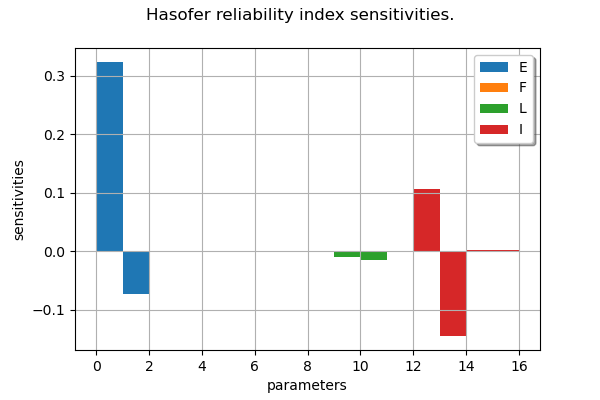

In [34]:
graph = result.drawHasoferReliabilityIndexSensitivity()[0]
graph.setLegends(X.getDescription())
graph.setTitle("Hasofer reliability index sensitivities.")
graph

## Bonus

In [35]:
u0 = [designPointStandardSpace[0]]
print("abscissa of the design point u0  = ", u0[0])

abscissa of the design point u0  =  -0.6048063667169543


In [36]:
standardEvent = ot.StandardEvent(event)
limitStateFunction = standardEvent.getFunction()
# Compute gradient
gradient = limitStateFunction.gradient(designPointStandardSpace)
# Get first column
gradientLimitStateFunction = gradient * ot.Point(1, 1.0)
gradientLimitStateFunction

class=Point name=Unnamed dimension=4 values=[-3.27693,12.5955,1.35902,-2.95776]

In [37]:
# Compute Hessian
hessian = limitStateFunction.hessian(designPointStandardSpace)# Get first sheet 
hessianLimitStateFunction = ot.SquareMatrix(hessian.getNbRows());
for i in range(hessian.getNbRows()):
    for j in range(hessian.getNbColumns()):
        hessianLimitStateFunction[i, j] = hessian[i, j, 0]
hessianLimitStateFunction

class=SquareMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[-2.47823,-1.37582,-0.148447,0.32308,-1.37582,6.98434,0.570582,-1.24181,-0.148447,0.570582,-0.300334,-0.133989,0.32308,-1.24181,-0.133989,0.529089]